# References

* Build VGG16: https://www.youtube.com/watch?v=oDHpqu52soI&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=13
* Train VGG16: https://www.youtube.com/watch?v=INaX55V1zpY&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=14
* Predict VGG16: https://www.youtube.com/watch?v=HDom7mAxCdc&index=15&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL

In [23]:
!pip list

Package             Version
------------------- -------
absl-py             0.5.0  
appnope             0.1.0  
astor               0.7.1  
backcall            0.1.0  
bleach              3.0.0  
cycler              0.10.0 
decorator           4.3.0  
defusedxml          0.5.0  
entrypoints         0.2.3  
gast                0.2.0  
grpcio              1.15.0 
h5py                2.8.0  
ipykernel           5.0.0  
ipython             7.0.1  
ipython-genutils    0.2.0  
ipywidgets          7.4.2  
jedi                0.13.1 
Jinja2              2.10   
jsonschema          2.6.0  
jupyter             1.0.0  
jupyter-client      5.2.3  
jupyter-console     6.0.0  
jupyter-core        4.4.0  
Keras               2.2.4  
Keras-Applications  1.0.6  
Keras-Preprocessing 1.0.5  
kiwisolver          1.0.1  
Markdown            3.0.1  
MarkupSafe          1.0    
matplotlib          2.2.3  
mistune             0.8.3  
nbconvert           5.4.0  
nbformat            4.4.0  
notebook            

In [24]:
!tree candd

candd
├── test
│   ├── cat
│   │   ├── 140.jpg
│   │   ├── 156.jpg
│   │   ├── 157.jpg
│   │   ├── 162.jpg
│   │   └── 163.jpg
│   └── dog
│       ├── 1040.jpg
│       ├── 1048.jpg
│       ├── 1070.jpg
│       ├── 146.jpg
│       └── 147.jpg
├── train
│   ├── cat
│   │   ├── 10.jpg
│   │   ├── 100.jpg
│   │   ├── 103.jpg
│   │   ├── 104.jpg
│   │   ├── 107.jpg
│   │   ├── 11.jpg
│   │   ├── 114.jpg
│   │   ├── 115.jpg
│   │   ├── 116.jpg
│   │   ├── 117.jpg
│   │   ├── 121.jpg
│   │   ├── 122.jpg
│   │   ├── 123.jpg
│   │   ├── 124.jpg
│   │   ├── 12479.jpg
│   │   ├── 128.jpg
│   │   ├── 129.jpg
│   │   ├── 13.jpg
│   │   ├── 15.jpg
│   │   └── 16.jpg
│   └── dog
│       ├── 1003.jpg
│       ├── 1006.jpg
│       ├── 1007.jpg
│       ├── 1010.jpg
│       ├── 1014.jpg
│       ├── 1019.jpg
│       ├── 102.jpg
│       ├── 1037.jpg
│       ├── 1038.jpg
│       ├── 1044.jpg
│       ├── 1053.jpg
│       ├── 1059.jpg
│       ├── 1067.jpg
│       ├── 1068.jpg
│       ├── 112.jpg
│       ├── 11

# Imports

In [25]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# Functions

In [26]:
# https://github.com/smileservices/keras_utils/blob/master/utils.py
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [27]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Setup

In [28]:
# https://www.kaggle.com/c/dogs-vs-cats/data
train_path = 'candd/train' # 20
valid_path = 'candd/valid' # 8
test_path = 'candd/test'   # 5

In [29]:
# https://keras.io/preprocessing/image/
# cats, dogs: 20, 20
train_steps = 4
train_batches = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=True
)

Found 40 images belonging to 2 classes.


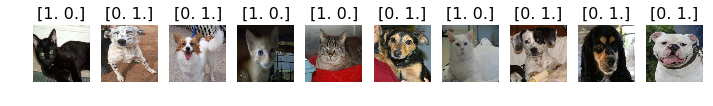

In [30]:
train_imgs, train_labels = next(train_batches)
plots(train_imgs, titles=train_labels)

In [31]:
# cats, dogs: 8, 8
valid_steps = 4
valid_batches = ImageDataGenerator().flow_from_directory(
    valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=4, shuffle=True
)

Found 16 images belonging to 2 classes.


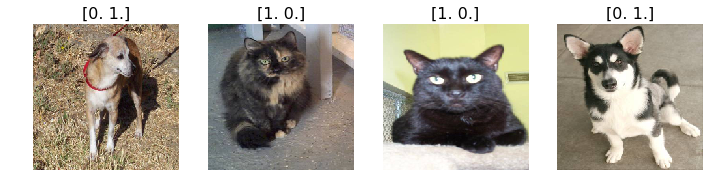

In [32]:
valid_imgs, valid_labels = next(valid_batches)
plots(valid_imgs, titles=valid_labels)

# Build Fine-Tuned VGG16 Model

In [33]:
vgg16_model = keras.applications.vgg16.VGG16()

In [34]:
# vgg16_model.summary()

In [35]:
type(vgg16_model)

keras.engine.training.Model

In [36]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [37]:
# model.summary()

In [38]:
# model.layers.pop()
# should remove the last layer but there is a bug in the current model implementation,
# so we simply don't add the last layer to this model (see for loop above)

In [39]:
# model.summary()

In [40]:
# Existing layers in VGG16 have been trained on images so we dont want to do that again. Only train the last layer.
for layer in model.layers:
    layer.trainable = False

In [41]:
model.add(Dense(2, activation='softmax'))

In [42]:
# model.summary()

In [43]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Fine-Tuned VGG16 Model

In [44]:
model.fit_generator(
    train_batches, steps_per_epoch=train_steps, validation_data=valid_batches, validation_steps=valid_steps, epochs=10, verbose=1
)

Epoch 1/10
4/4 [==============================] - 28s 7s/step - loss: 0.5376 - acc: 0.7750 - val_loss: 0.2541 - val_acc: 0.9375
Epoch 2/10
4/4 [==============================] - 27s 7s/step - loss: 0.3392 - acc: 0.8750 - val_loss: 0.5664 - val_acc: 0.8125
Epoch 3/10
4/4 [==============================] - 27s 7s/step - loss: 0.2190 - acc: 0.9250 - val_loss: 0.1905 - val_acc: 0.9375
Epoch 4/10
4/4 [==============================] - 28s 7s/step - loss: 0.1896 - acc: 0.9250 - val_loss: 0.3415 - val_acc: 0.8750
Epoch 5/10
4/4 [==============================] - 30s 7s/step - loss: 0.1083 - acc: 0.9750 - val_loss: 0.5207 - val_acc: 0.8125
Epoch 6/10
4/4 [==============================] - 33s 8s/step - loss: 0.1029 - acc: 0.9750 - val_loss: 0.2871 - val_acc: 0.8750
Epoch 7/10
4/4 [==============================] - 28s 7s/step - loss: 0.0698 - acc: 0.9500 - val_loss: 0.1768 - val_acc: 0.8750
Epoch 8/10
4/4 [==============================] - 29s 7s/step - loss: 0.0303 - acc: 1.0000 - val_loss: 0

# Setup Test Batches

In [93]:
# cats, dogs: 5, 5
test_steps = 2
test_batches = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=5, shuffle=False
)

Found 10 images belonging to 2 classes.


# Setup Test

test_imgs, test_labels = next(test_batches)

test_labels = test_labels[:,0]
test_labels

plots(test_imgs, titles=test_labels)

# Predict using Fine-Tuned VGG16 Model

In [94]:
predictions = model.predict_generator(test_batches, steps=test_steps, verbose=0)

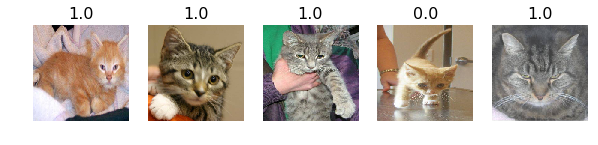

In [95]:
plots(test_imgs, titles=np.round(predictions[:,0]))

In [96]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

ValueError: Found input variables with inconsistent numbers of samples: [5, 10]

In [ ]:
cm_plot_labels = ['dog','cat']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Save Model

In [ ]:
# model.save('cats-and-dogs_20-8-5_VGG16.h5')